# FINAL

In [1]:
import gym
import torch
import torch.nn as nn
from itertools import chain
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
from torch.utils.data import Dataset, DataLoader
import numpy as np
from collections import deque

# Q-Value Network
class QNetwork(nn.Module):
    def __init__(self, state_size, action_size):
        super().__init__()
        hidden_size = 8
        self.net = nn.Sequential(nn.Linear(state_size, hidden_size),
                                 nn.ReLU(),
                                 nn.Linear(hidden_size, hidden_size),
                                 nn.ReLU(),
                                 nn.Linear(hidden_size, hidden_size),
                                 nn.ReLU(),
                                 nn.Linear(hidden_size, action_size))
        
    def forward(self, x):
        """Estimate q-values given state
        Args:
            state (tensor): current state, size (batch x state_size)
        Returns:
            q-values (tensor): estimated q-values, size (batch x action_size)
        """
        return self.net(x)

In [2]:
def get_action_dqn(network, state, epsilon, epsilon_decay):
    rand = random.random()
    if rand < epsilon:
        return random.randint(0, 1), epsilon * epsilon_decay
    else:
        state = np.float32(state)
        state = torch.tensor(state).unsqueeze(0).cuda()
        return torch.argmax(network(state)).item(), epsilon * epsilon_decay

def prepare_batch(memory, batch_size):
    """Randomly sample batch from memory and prepare cuda tensors
    Args:
        memory (list): state, action, next_state, reward, done tuples
        batch_size (int): amount of memory to sample into a batch
    Returns:
        state (tensor): float cuda tensor of size (batch_size x state_size)
        action (tensor): long tensor of size (batch_size)
        next_state (tensor): float cuda tensor of size (batch_size x state_size)
        reward (tensor): float cuda tensor of size (batch_size)
        done (tensor): float cuda tensor of size (batch_size)
    """
    slices = np.random.randint(0, len(memory), batch_size)
    batch = [memory[idx] for idx in slices]
    state, action, next_state, reward, done = zip(*batch)

    state = torch.tensor(state).float().cuda()
    action = torch.tensor(action).long().cuda()
    next_state = torch.tensor(next_state).float().cuda()
    reward = torch.tensor(reward).float().cuda()
    done = torch.tensor(done).float().cuda()

    return state, action, next_state, reward, done

In [3]:
def learn_dqn(batch, optim, q_network, target_network, gamma, global_step, target_update):
    """Update Q-Network according to DQN Loss function
    Update Target Network every target_update global steps
    Args:
        batch (tuple): tuple of state, action, next_state, reward, and done tensors
        optim (Adam): Q-Network optimizer
        q_network (QNetwork): Q-Network
        target_network (QNetwork): Target Q-Network
        gamma (float): discount factor
        global_step (int): total steps taken in environment
        target_update (int): frequency of target network update
    """
    state, action, next_state, reward, done = batch
    batch_size = state.size(0)

    q_values = q_network(state)
    next_q_values = target_network(next_state)
    next_q_state_values = next_q_values.max(1)[0]

    q_value = q_values.gather(1, action.unsqueeze(1)).squeeze(1)
    expected_q_value = reward + gamma * next_q_state_values * (1 - done)

    loss = (q_value - expected_q_value.detach()).pow(2).mean()

    optim.zero_grad()
    loss.backward()
    optim.step()

    if global_step % target_update == 0:
        target_network.load_state_dict(q_network.state_dict())
        print('Updated target network.')

    return loss.item()

  0%|                                                                                     | 0/500 [00:00<?, ?it/s]D:\Python\Python 3.11.0\Lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
Episodes: 46 Reward: 45.0:   9%|████▌                                            | 47/500 [00:22<04:40,  1.61it/s]C:\Users\Swarup\AppData\Local\Temp\ipykernel_16952\2870465981.py:26: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:278.)
  state = torch.tensor(state).float().cuda()
Episodes: 103 Reward: 25.0:  21%|█████████▊                                     | 104/500 [00:45<02:44,  2.41it/s]

Updated target network.


Episodes: 157 Reward: 18.0:  32%|██████████████▊                                | 158/500 [01:08<02:23,  2.38it/s]

Updated target network.


Episodes: 203 Reward: 32.0:  41%|███████████████████▏                           | 204/500 [01:30<02:42,  1.82it/s]

Updated target network.


Episodes: 238 Reward: 15.0:  48%|██████████████████████▍                        | 239/500 [01:51<02:28,  1.76it/s]

Updated target network.


Episodes: 275 Reward: 28.0:  55%|█████████████████████████▉                     | 276/500 [02:13<02:38,  1.41it/s]

Updated target network.


Episodes: 304 Reward: 47.0:  61%|████████████████████████████▋                  | 305/500 [02:34<02:49,  1.15it/s]

Updated target network.


Episodes: 327 Reward: 62.0:  66%|██████████████████████████████▊                | 328/500 [02:55<02:35,  1.11it/s]

Updated target network.


Episodes: 343 Reward: 48.0:  69%|████████████████████████████████▎              | 344/500 [03:16<04:06,  1.58s/it]

Updated target network.


Episodes: 357 Reward: 72.0:  72%|█████████████████████████████████▋             | 358/500 [03:39<03:30,  1.48s/it]

Updated target network.


Episodes: 368 Reward: 69.0:  74%|██████████████████████████████████▋            | 369/500 [04:00<04:15,  1.95s/it]

Updated target network.


Episodes: 377 Reward: 94.0:  76%|███████████████████████████████████▌           | 378/500 [04:21<04:33,  2.24s/it]

Updated target network.


Episodes: 384 Reward: 151.0:  77%|███████████████████████████████████▍          | 385/500 [04:41<05:38,  2.94s/it]

Updated target network.


Episodes: 390 Reward: 168.0:  78%|███████████████████████████████████▉          | 391/500 [05:01<05:54,  3.25s/it]

Updated target network.


Episodes: 395 Reward: 159.0:  79%|████████████████████████████████████▍         | 396/500 [05:24<06:59,  4.04s/it]

Updated target network.


Episodes: 402 Reward: 105.0:  81%|█████████████████████████████████████         | 403/500 [05:47<05:08,  3.18s/it]

Updated target network.


Episodes: 408 Reward: 200.0:  82%|█████████████████████████████████████▋        | 409/500 [06:08<05:38,  3.72s/it]

Updated target network.


Episodes: 414 Reward: 192.0:  83%|██████████████████████████████████████▏       | 415/500 [06:29<05:20,  3.77s/it]

Updated target network.


Episodes: 419 Reward: 200.0:  84%|██████████████████████████████████████▋       | 420/500 [06:50<05:29,  4.11s/it]

Updated target network.


Episodes: 424 Reward: 200.0:  85%|███████████████████████████████████████       | 425/500 [07:11<05:11,  4.15s/it]

Updated target network.


Episodes: 429 Reward: 200.0:  86%|███████████████████████████████████████▌      | 430/500 [07:31<04:48,  4.12s/it]

Updated target network.


Episodes: 435 Reward: 174.0:  87%|████████████████████████████████████████      | 436/500 [07:54<03:57,  3.71s/it]

Updated target network.


Episodes: 440 Reward: 184.0:  88%|████████████████████████████████████████▌     | 441/500 [08:12<03:41,  3.76s/it]

Updated target network.


Episodes: 445 Reward: 193.0:  89%|█████████████████████████████████████████     | 446/500 [08:32<03:32,  3.94s/it]

Updated target network.


Episodes: 451 Reward: 177.0:  90%|█████████████████████████████████████████▌    | 452/500 [08:59<03:41,  4.61s/it]

Updated target network.


Episodes: 456 Reward: 200.0:  91%|██████████████████████████████████████████    | 457/500 [09:19<02:59,  4.18s/it]

Updated target network.


Episodes: 461 Reward: 200.0:  92%|██████████████████████████████████████████▌   | 462/500 [09:40<02:36,  4.11s/it]

Updated target network.


Episodes: 467 Reward: 179.0:  94%|███████████████████████████████████████████   | 468/500 [10:03<02:02,  3.84s/it]

Updated target network.


Episodes: 472 Reward: 199.0:  95%|███████████████████████████████████████████▌  | 473/500 [10:24<01:50,  4.11s/it]

Updated target network.


Episodes: 477 Reward: 186.0:  96%|███████████████████████████████████████████▉  | 478/500 [10:44<01:27,  3.98s/it]

Updated target network.


Episodes: 482 Reward: 200.0:  97%|████████████████████████████████████████████▍ | 483/500 [11:04<01:09,  4.09s/it]

Updated target network.


Episodes: 487 Reward: 200.0:  98%|████████████████████████████████████████████▉ | 488/500 [11:25<00:49,  4.14s/it]

Updated target network.


Episodes: 492 Reward: 200.0:  99%|█████████████████████████████████████████████▎| 493/500 [11:45<00:29,  4.15s/it]

Updated target network.


Episodes: 497 Reward: 200.0: 100%|█████████████████████████████████████████████▊| 498/500 [12:06<00:08,  4.16s/it]

Updated target network.


Episodes: 499 Reward: 177.0: 100%|██████████████████████████████████████████████| 500/500 [12:14<00:00,  4.01s/it]

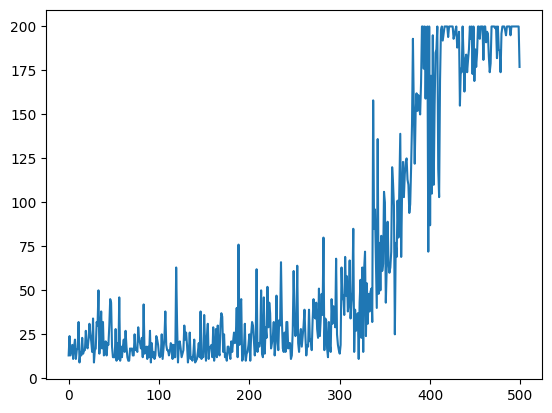

In [4]:
def dqn_main():
    # Hyper parameters
    lr = 1e-3
    epochs = 500
    start_training = 1000
    gamma = 0.99
    batch_size = 32
    epsilon = 1
    epsilon_decay = 0.9999
    target_update = 1000
    learn_frequency = 2
    render_interval = 50  # Render every 50 episodes

    # Init environment
    state_size = 4
    action_size = 2
    env = gym.make('CartPole-v1', render_mode='human')

    # Init networks
    q_network = QNetwork(state_size, action_size).cuda()
    target_network = QNetwork(state_size, action_size).cuda()
    target_network.load_state_dict(q_network.state_dict())

    # Init optimizer
    optim = torch.optim.Adam(q_network.parameters(), lr=lr)

    # Init replay buffer
    memory = deque(maxlen=10000)

    # Begin main loop
    results_dqn = []
    global_step = 0
    loop = tqdm(total=epochs, position=0, leave=False)
    for epoch in range(epochs):
        # Reset environment
        state = env.reset()[0]
        done = False
        cum_reward = 0  # Track cumulative reward per episode

        # Begin episode
        while not done and cum_reward < 200:  # End after 200 steps 
            if epoch % render_interval == 0:
                env.render()  # Render the environment for visualization
            
            # Select e-greedy action
            action, epsilon = get_action_dqn(q_network, state, epsilon, epsilon_decay)
            # Take step
            next_state, reward, done, *_ = env.step(action)
            # env.render()

            # Store step in replay buffer
            memory.append((state, action, next_state, reward, done))

            cum_reward += reward
            global_step += 1  # Increment total steps
            state = next_state  # Set current state

            # If time to train
            if global_step > start_training and global_step % learn_frequency == 0:
                # Sample batch
                batch = prepare_batch(memory, batch_size)
                # Train
                learn_dqn(batch, optim, q_network, target_network, gamma, global_step, target_update)

        # Print results at end of episode
        results_dqn.append(cum_reward)
        loop.update(1)
        loop.set_description(f'Episodes: {epoch} Reward: {cum_reward}')

    env.close()
    return results_dqn

results_dqn = dqn_main()

plt.plot(results_dqn)
plt.show()